# This cat does not exist
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW06] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

Цель этого задания - создать котов, которых не существует. В ходе данного задания вы обучите DCGAN и VAE, которые являются одними из первых генеративных моделей. Для этого задания вам наверняка потребуется GPU с CUDA, поэтому рекомендуется использовать Google Colab.

In [227]:
# from google.colab import drive
# drive.mount('/content/drive')

# DATA_PATH = "/content/drive/MyDrive/data/cat_136/cat_136"
DATA_PATH = "cat_136"

In [228]:
import os 
import cv2
import torch
import random

import numpy as np
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm

from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


%matplotlib inline

In [229]:
def random_noise(batch_size, channels, side_size):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return torch.randn(batch_size, channels, side_size, side_size).to(device)

def imagewide_average(x):
    return x.mean(dim=(-1, -2))

In [230]:
def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs, vmin=0, vmax=1)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [231]:
class CatDataset(Dataset):
    def __init__(self, data_path="cat_136", size=64):
        self.photo_names = os.listdir(data_path)
        self.path_base = data_path
        self.size = size
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:512 - crop_rate + x_crop, y_crop:512 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_AREA)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1
    
    #     def __getitem__(self, index):
#         path = self.path_base + "/" + self.photo_names[index]
#         img = cv2.resize(cv2.imread(path), (self.size, self.size), interpolation=cv2.INTER_AREA) # 136 x 136 -> 64 x 64
        
#         return torch.tensor(img).float().transpose(0, 2) / 255
    
    def __len__(self):
        return len(self.photo_names)

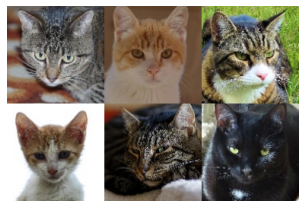

In [232]:
dataset = CatDataset(size=128)
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 15, 182, 592, 394, 2941]], dim=0))

### Задание 1 (2 балла)
Для начала реализуем генератор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](imgs/DCGAN.png)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ConvTranspose2D`, `nn.ReLU`, а также функция `F.interpolate`.

#### Методы
* `__init__` - принимает на вход `start_size`, `latent_channels`, `start_channels` и `upsamplings`. Первые два аргумента отвечают за размер случайного шума, из которого в последствии будет сгенерирована картинка. `start_channels` отвечает за то, сколько каналов должно быть в картинке перед тем, как к ней будут применены upsampling блоки. `upsamplings` - это количество upsampling блоков, которые должны быть применены к картинке. В каждом таком локе количество каналов уменьшается в два раза.


* `forward` - принимает на вход `batch_size`, генерирует `batch_size` картинок из случайного шума.

In [233]:
def upsample_block(in_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=in_channels // 2),
        nn.ReLU()
    )

In [234]:
class Generator(nn.Module):
    def __init__(self, start_size=2, latent_channels=32, start_channels=1024, upsamplings=6):
        super().__init__()
        
        self.start_size = start_size
        self.latent_channels = latent_channels
        
        self.conv_start = nn.Conv2d(latent_channels, start_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.upsamples = nn.Sequential(
            *[upsample_block(start_channels // 2**i) for i in range(upsamplings)]
        )
        self.conv_end = nn.Conv2d(start_channels // 2**upsamplings, 3, kernel_size=1, stride=1, padding=0, bias=False)        
    
    def forward(self, batch_size: int):
        out = random_noise(batch_size, self.latent_channels, self.start_size)

        out = self.conv_start(out)
        out = self.upsamples(out)
        out = self.conv_end(out)
        
        return torch.tanh(out) # (batch_size, 3, start_size * 2**upsamplings, start_size * 2**upsamplings)

### Задание 2 (2 балла)
Для начала реализуем дискриминатор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](imgs/Disc_DCGAN.png)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ReLU` и `nn.Sigmoid`.

#### Методы
* `__init__` - принимает на вход `start_channels` и `downsamplings`. `start_channels` определяет количество каналов, которые должны быть в изображении перед применением downsampling блоков.


* `forward` - принимает на вход `x` - тензор с картинками. Возвращает вектор с размерностью `batch_size`.

In [235]:
def downsample_block(in_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, stride=2, padding=1, bias=False), # kernel_size=4 ?
        nn.BatchNorm2d(in_channels * 2),
        nn.ReLU()
    )

In [236]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, downsamplings=6, start_channels=8):
        super().__init__()
    
        scale = 2**downsamplings
        
        self.conv_start = nn.Conv2d(3, start_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.downsamples = nn.Sequential(
            *[downsample_block(start_channels * 2**i) for i in range(downsamplings)]
        )
        self.linear_end = nn.Linear((start_channels * scale) * (input_shape // scale) * (input_shape // scale), 1)
                
    def forward(self, x):
        out = self.conv_start(x)
        out = self.downsamples(out)
        out = self.linear_end(out.flatten(start_dim=1))
        
        return torch.sigmoid(out) # torch.Tensor batch_size x 1

In [237]:
config_gen_128 = {
    "start_size": 2, 
    "latent_channels": 64, # default 32
    "start_channels": 1024,
    "upsamplings": 6 
    }

config_dis_128 = {
    "input_shape": config_gen_128["start_size"] * 2**config_gen_128["upsamplings"],
    "downsamplings": 5, 
    "start_channels": 8, # default 8
    }


# TODO: add load_model path for generator and discriminator
config = {
    "generator": config_gen_128,
    "discriminator": config_dis_128,
    "dataset_image_size": 128,
    "dataset_path": DATA_PATH
}

In [243]:
test_g = Generator(**config_gen_128)
test_d = Discriminator(**config_dis_128)

test_d(test_g(1))

tensor([[0.4664]], grad_fn=<SigmoidBackward>)

In [210]:
def train_gan(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Training on: ", device)
    
    generator = Generator(**config["generator"]).to(device)
    discriminator = Discriminator(**config["discriminator"]).to(device)
    
    epochs = 120
    visualise_every = 5
    batch_size = 8

    gen_optim = Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    disc_optim = Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    dataset = CatDataset(data_path=config["dataset_path"], size=config["dataset_image_size"])

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        gen_loss_avg = 0
        disc_loss_avg = 0

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            
            # Positive update
            batch = batch.to(device)
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Negative update
            batch = generator(batch_size).detach()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.zeros_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Generator update
            batch = generator(batch_size)
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_loss_avg += loss.item()
            
        if (ep + 1) % visualise_every == 0:
            with torch.no_grad():
                visualise(generator(2 * 6), rows=2)
        
        torch.save(generator, "generator")
        torch.save(discriminator, "discriminator")

        print(f"Epoch {ep+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")
    return generator

In [ ]:
train_gan(config)

In [ ]:
with torch.no_grad():
    visualise(generator(5 * 12), rows=5)

### Задание 3 (5 баллов)
Теперь посмотрим на другую модель: Variational Autoencoder. В отличии от GAN, в котором генератор пытается себя обмануть дискриминатор, а дискриминатор старается не быть обманутым, VAE решает задачу реконструкции элемента множества X с применением регуляризации в латентном пространстве. 

Полностью архитектура выглядит так:
![](imgs/VAE.png)

Из нее можно выделить две части: Encoder (по изображению возвращает mu и sigma) и Decoder (по случайному шуму восстанавливает изображение). На высоком уровне VAE можно представить так:

![](imgs/VAE_highlevel.png)

В данном задании вам необходимо реализовать полную архитектуру VAE.

#### Методы
* `__init__` - принимает на вход `img_size`, `latent_size`, `down_channels` и `up_channels`. `img_size` - размер стороны входного изображения. `latent_size` - размер латентного пространства, в который будет закодирована картинка. `down_channels` - количество каналов, в которое будет преобразовано трехцветное изображение перед применением `downsampling` блоков. `up_channels` - количество каналов, которое должно получиться после применения всех upsampling блоков.

* `forward` - принимает на вход `x`. Считает распределение $N(\mu, \sigma^2)$ и вектор $z \sim N(\mu, \sigma^2)$. Возвращает $x'$ - восстановленную из вектора $z$ картинку и $D_{KL}(N(\mu, \sigma^2), N(0, 1)) = 0.5 \cdot (\sigma^2 + \mu^2 - \log \sigma^2 - 1)$.

* `encode` - принимает на вход `x`. Возвращает вектор из распределения $N(\mu, \sigma^2)$.

* `decode` - принимает на вход `z`. Возвращает восстановленную по вектору картинку.


#### Если хочется улучшить качество
https://arxiv.org/pdf/1906.00446.pdf

In [217]:
def downsample_block_vae(in_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(in_channels * 2),
        nn.ReLU()
    )

def upsample_block_vae(in_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=in_channels // 2),
        nn.ReLU()
    )

In [218]:
class VAE(nn.Module):
    def __init__(self, img_size=128, latent_size=512, down_channels=8, up_channels=16):
        super().__init__()
    
        downsamplings = int(np.log2(img_size))
        assert img_size % 2**downsamplings == 0.0, "img size should be a power of two"
        
        self.latent_size = latent_size        
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, down_channels, kernel_size=1, stride=1, padding=0),
            nn.Sequential(
                *[downsample_block_vae(down_channels * 2**i) for i in range(downsamplings)]
            ),
            nn.Conv2d(down_channels * 2**downsamplings, 2 * latent_size, kernel_size=1, stride=1, padding=0)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_size, up_channels * 2**downsamplings, kernel_size=1, stride=1, padding=0),
            nn.Sequential(
                *[upsample_block_vae(up_channels * 2**(downsamplings - i)) for i in range(downsamplings)]
            ),
            nn.Conv2d(up_channels, 3, kernel_size=1, stride=1, padding=0),
            nn.Tanh()
        )
        
    def forward(self, x):
        z, (mu, sigma) = self.encode(x, forward=True)
        
        x_pred, kld = self.decode(z), self.kl_loss(mu, sigma)           
        
        return x_pred, kld
    
    def encode(self, x, forward=False):
        mu, sigma = torch.split(self.encoder(x), self.latent_size, dim=1)
        z = mu + torch.randn_like(sigma) * sigma
        
        if forward:
            return z, (mu, sigma)

        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def kl_loss(self, mu, sigma):
        var = sigma ** 2

#         return torch.sum(0.5 * (var + mu**2 - torch.log(var) - 1))  / mu.shape[0] # mode='batchmean'
        return 0.5 * (var + mu**2 - torch.log(var) - 1)

In [219]:
config = {
    "vae": {
        "img_size": 128,
        "latent_size": 512,
        "down_channels": 8,
        "up_channels": 16,
    },
    "dataset_image_size": 128,
    "dataset_path": DATA_PATH
}

In [222]:
def train_vae(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Training on: ", device)
    
    vae = VAE(**config["vae"]).to(device)

    epochs = 201
    batch_size = 8
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    dataset = CatDataset(data_path=config["dataset_path"], size=config["dataset_image_size"])

    test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0

        if ep % 10 == 0:
            with torch.no_grad():
                z_1 = vae.encode(test_imgs_1.to(device))
                z_2 = vae.encode(test_imgs_2.to(device))
                x_int = []
                for i in range(9):
                    z = (i * z_1 + (8 - i) * z_2) / 8
                    x_int.append(vae.decode(z))
                x_int = torch.cat(x_int)
                visualise(x_int, rows=len(test_imgs_1))
                z_rand = torch.randn_like(z_1)
                x_int = vae.decode(z_rand)
                visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x = batch.to(device)
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x)**2).sum() / batch_size
            loss = rec_loss + 0.1 * kld_loss # https://openreview.net/forum?id=Sy2fzU9gl
            
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()

        torch.save(vae, "autoencoder")
        print(f"Epoch {ep+1} | Reconstruction loss: {rec_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")

Training on:  cpu


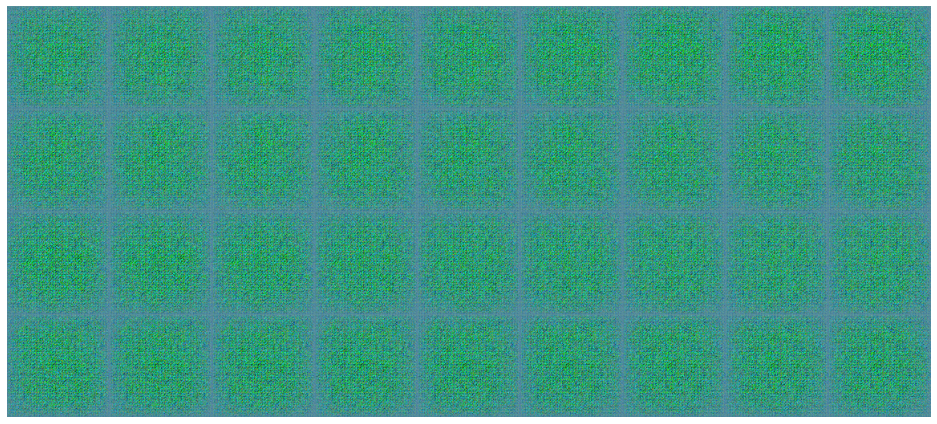

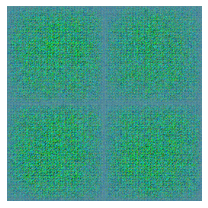

KeyboardInterrupt: 

In [221]:
train_vae(config)